In [11]:
# Cell 1: Setup Google Colab Environment
import os
import sys

# Check if running on Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running on Google Colab")

    # Check GPU availability
    import tensorflow as tf
    print("GPU Available: ", tf.config.list_physical_devices('GPU'))

    # Set GPU memory growth to avoid OOM errors
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("GPU memory growth enabled")
        except RuntimeError as e:
            print(e)

    # Mount Google Drive (optional - if your data is in Drive)
    from google.colab import drive
    # drive.mount('/content/drive')

else:
    print("Not running on Colab")

# Standard imports
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

Running on Google Colab
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU memory growth enabled


In [12]:
# Cell 2: Load CSV Data with Robust Error Handling
from pathlib import Path

def load_data():
    """Load CSV files from specified paths with robust error handling"""

    file_paths = [
        '/content/sample_data/Phishing_Email.csv',
        '/content/sample_data/test.csv',
        '/content/sample_data/train.csv'
    ]

    dfs = []
    loaded_files = []

    for file_path in file_paths:
        if Path(file_path).exists():
            filename = Path(file_path).name

            # Try multiple parsing strategies for problematic files
            parsing_strategies = [
                # Strategy 1: Default pandas read_csv
                {"func": pd.read_csv, "kwargs": {}},

                # Strategy 2: Handle quote issues (pandas 1.x compatible)
                {"func": pd.read_csv, "kwargs": {
                    "quoting": 3,  # QUOTE_NONE
                    "escapechar": '\\',
                    "on_bad_lines": 'skip'
                }},

                # Strategy 3: Use different engine with error handling
                {"func": pd.read_csv, "kwargs": {
                    "engine": 'python',
                    "quoting": 3,
                    "on_bad_lines": 'skip'
                }},

                # Strategy 4: Skip bad lines and handle encoding
                {"func": pd.read_csv, "kwargs": {
                    "encoding": 'utf-8',
                    "on_bad_lines": 'skip',
                    "quoting": 3
                }},

                # Strategy 5: Try different encoding
                {"func": pd.read_csv, "kwargs": {
                    "encoding": 'latin-1',
                    "on_bad_lines": 'skip'
                }}
            ]

            df = None
            for i, strategy in enumerate(parsing_strategies, 1):
                try:
                    df = strategy["func"](file_path, **strategy["kwargs"])
                    print(f"✅ Loaded {filename} (Strategy {i}): {df.shape}")
                    break
                except Exception as e:
                    if i == len(parsing_strategies):
                        print(f"❌ All strategies failed for {filename}. Last error: {e}")
                    continue

            if df is not None:
                dfs.append(df)
                loaded_files.append(filename)

        else:
            print(f"⚠️ File not found: {Path(file_path).name}")

    if not dfs:
        print("❌ No files could be loaded!")
        return None

    # Combine all files
    result = pd.concat(dfs, ignore_index=True) if len(dfs) > 1 else dfs[0]
    print(f"📊 Combined dataset: {result.shape}")
    print(f"📁 Files used: {', '.join(loaded_files)}")

    return result

# Load the data
print("=== Loading Data ===")
df = load_data()

# Early exit if no data loaded
if df is None:
    print("❌ Cannot proceed without data. Please check your file paths.")
    exit()

=== Loading Data ===
✅ Loaded Phishing_Email.csv (Strategy 1): (18650, 3)
✅ Loaded test.csv (Strategy 1): (5591, 2)
✅ Loaded train.csv (Strategy 1): (13043, 2)
📊 Combined dataset: (37284, 4)
📁 Files used: Phishing_Email.csv, test.csv, train.csv


In [13]:
# Cell 3: Data Preprocessing
def preprocess_text(text):
    """Clean email text"""
    if pd.isna(text):
        return ""

    text = str(text).lower()
    text = re.sub(r'http[s]?://\S+', '', text)  # Remove URLs
    text = re.sub(r'\S+@\S+', '', text)         # Remove emails
    text = re.sub(r'<.*?>', '', text)           # Remove HTML
    text = re.sub(r'[^a-zA-Z\s]', '', text)     # Keep only letters
    text = ' '.join(text.split())               # Remove extra spaces

    return text

# Find text and label columns automatically
print("\n=== Data Preprocessing ===")
text_col = None
label_col = None

print("Available columns:", list(df.columns))
print("Column info:")
for col in df.columns:
    print(f"  {col}: {df[col].dtype}, unique values: {df[col].nunique()}")

# Automatic column detection
for col in df.columns:
    if any(word in col.lower() for word in ['email', 'text', 'body', 'content', 'message']):
        text_col = col
        break

for col in df.columns:
    if any(word in col.lower() for word in ['type', 'label', 'class', 'target', 'phishing']):
        label_col = col
        break

# Fallback: use columns with appropriate characteristics
if text_col is None:
    # Look for column with long text (likely email content)
    for col in df.columns:
        if df[col].dtype == 'object':
            avg_length = df[col].astype(str).str.len().mean()
            if avg_length > 50:  # Assuming email text is longer
                text_col = col
                break

if label_col is None:
    # Look for column with few unique values (likely labels)
    for col in df.columns:
        if df[col].dtype == 'object' and df[col].nunique() <= 10:
            label_col = col
            break

# Manual fallback
if text_col is None and len(df.columns) > 0:
    text_col = df.columns[0]
    print(f"Auto-detection failed. Using first column as text: {text_col}")

if label_col is None and len(df.columns) > 1:
    label_col = df.columns[-1]
    print(f"Auto-detection failed. Using last column as label: {label_col}")

print(f"\nUsing text column: {text_col}")
print(f"Using label column: {label_col}")

# Validate columns exist and have data
if text_col not in df.columns or label_col not in df.columns:
    print("Required columns not found!")
    exit()

# Clean and prepare data
print("\nCleaning data...")
df = df.dropna(subset=[text_col, label_col])

if len(df) == 0:
    print("No valid data remaining after removing nulls!")
    exit()

df['clean_text'] = df[text_col].apply(preprocess_text)

# Remove rows with empty cleaned text
df = df[df['clean_text'].str.len() > 0]

print(f"Dataset shape after cleaning: {df.shape}")
print(f"Label distribution:")
print(df[label_col].value_counts())


=== Data Preprocessing ===
Available columns: ['Unnamed: 0', 'Email Text', 'Email Type', 'Label']
Column info:
  Unnamed: 0: float64, unique values: 18650
  Email Text: object, unique values: 17537
  Email Type: object, unique values: 2
  Label: object, unique values: 2

Using text column: Email Text
Using label column: Email Type

Cleaning data...
Dataset shape after cleaning: (18628, 5)
Label distribution:
Email Type
Safe Email        11321
Phishing Email     7307
Name: count, dtype: int64


In [14]:
def create_features(df, text_col):
    """Create additional email features"""
    features = pd.DataFrame()

    # Basic length features
    features['length'] = df[text_col].astype(str).str.len()
    features['word_count'] = df[text_col].astype(str).str.split().str.len()
    features['exclamation'] = df[text_col].astype(str).str.count('!')
    features['question'] = df[text_col].astype(str).str.count('\?')  # escape question mark

    # Calculate caps ratio safely
    def safe_caps_ratio(text):
        text = str(text)
        if len(text) == 0:
            return 0
        return sum(c.isupper() for c in text) / len(text)

    features['caps_ratio'] = df[text_col].apply(safe_caps_ratio)

    # Suspicious words
    suspicious_words = {
        'urgent': ['urgent'],
        'click': ['click'],
        'free': ['free'],
        'winner': ['winner', 'won'],
        'verify': ['verify', 'verification'],
        'congratulations': ['congratulations', 'congrat'],
        'limited': ['limited'],
        'offer': ['offer'],
        'act_now': ['act now', 'act immediately'],
        'money': ['money']
    }

    for key, words in suspicious_words.items():
        pattern = '|'.join([re.escape(w) for w in words])  # escape regex patterns
        features[key] = df[text_col].astype(str).str.contains(pattern, case=False, na=False).astype(int)

    return features  # make sure this is present


In [15]:
# Cell 4: Optimized Feature Creation and Extraction with LinearSVC (Google Colab Optimized)
import psutil
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC  # Much faster for linear kernels
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import numpy as np
from scipy.sparse import hstack
import time
import warnings
warnings.filterwarnings('ignore')  # Suppress convergence warnings

# Check Colab resources
print("🖥️ Google Colab System Info:")
print(f"CPU cores: {psutil.cpu_count()}")
print(f"RAM: {psutil.virtual_memory().total / (1024**3):.1f} GB")
print(f"Available RAM: {psutil.virtual_memory().available / (1024**3):.1f} GB")

# Check if GPU is available (optional)
try:
    import torch
    if torch.cuda.is_available():
        print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
    else:
        print("💻 Using CPU only")
except ImportError:
    print("💻 Using CPU only")

print("\n=== Feature Creation ===")

# Create additional email features
start_time = time.time()
email_features = create_features(df, 'clean_text')
print(f"Email features created: {email_features.shape}")
print(f"Feature columns: {list(email_features.columns)}")
print(f"Time taken: {time.time() - start_time:.2f} seconds")

# Extract TF-IDF features (REDUCED SIZE)
print("\n=== Text Feature Extraction ===")
start_time = time.time()
vectorizer = TfidfVectorizer(
    max_features=1000,  # REDUCED from 5000
    stop_words='english',
    ngram_range=(1, 1),  # REDUCED from (1,2) - removes bigrams
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95  # Ignore terms that appear in more than 95% of documents
)

# Convert text to numerical features
text_features = vectorizer.fit_transform(df['clean_text'])
print(f"TF-IDF features shape: {text_features.shape}")
print(f"Time taken: {time.time() - start_time:.2f} seconds")

# Combine email features with TF-IDF features
print("\n=== Combining Features ===")
start_time = time.time()
X = hstack([text_features, email_features.values])
y = df[label_col].values

print(f"Combined feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Time taken: {time.time() - start_time:.2f} seconds")

# Prepare data (same as before)
print("\n=== Preparing for training ===")
label_counts = Counter(y)
print(f"Original class distribution: {dict(label_counts)}")

valid_classes = [cls for cls, count in label_counts.items() if count >= 2]
if len(valid_classes) < len(label_counts):
    print(f"⚠️ Removing {len(label_counts) - len(valid_classes)} class(es) with <2 samples.")

# Convert to CSR format for indexing
X = X.tocsr()

# Filter X and y
valid_idx = [i for i, label in enumerate(y) if label in valid_classes]
X = X[valid_idx, :]
y = y[valid_idx]

# Split data
stratify_ok = len(set(y)) > 1 and all(count >= 2 for count in Counter(y).values())
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42,
        stratify=y if stratify_ok else None
    )
    print("Data split successful.")
except ValueError as e:
    print(f"⚠️ Stratified split failed: {e}")
    print("➡️ Falling back to random split without stratification.")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# OPTION 1: LinearSVC (FASTEST for linear kernels)
print("\n🚀 Training LinearSVC (Optimized for Linear Kernels)...")
start_time = time.time()

linear_svc = LinearSVC(C=1.0, random_state=42, max_iter=2000, dual=False)
linear_svc.fit(X_train, y_train)
y_pred_linear_svc = linear_svc.predict(X_test)

print(f"⏱️ LinearSVC training time: {time.time() - start_time:.2f} seconds")
print(f"🎯 LinearSVC Test Accuracy: {accuracy_score(y_test, y_pred_linear_svc):.4f}")

🖥️ Google Colab System Info:
CPU cores: 2
RAM: 12.7 GB
Available RAM: 9.9 GB
🚀 GPU: Tesla T4

=== Feature Creation ===
Email features created: (18628, 15)
Feature columns: ['length', 'word_count', 'exclamation', 'question', 'caps_ratio', 'urgent', 'click', 'free', 'winner', 'verify', 'congratulations', 'limited', 'offer', 'act_now', 'money']
Time taken: 6.50 seconds

=== Text Feature Extraction ===
TF-IDF features shape: (18628, 1000)
Time taken: 4.06 seconds

=== Combining Features ===
Combined feature matrix shape: (18628, 1015)
Labels shape: (18628,)
Time taken: 0.01 seconds

=== Preparing for training ===
Original class distribution: {'Safe Email': 11321, 'Phishing Email': 7307}
Data split successful.
Training set size: 13039
Test set size: 5589

🚀 Training LinearSVC (Optimized for Linear Kernels)...
⏱️ LinearSVC training time: 0.25 seconds
🎯 LinearSVC Test Accuracy: 0.9308


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

COMPREHENSIVE MODEL EVALUATION

📊 ACCURACY COMPARISON:
Training Accuracy: 0.9347 (93.47%)
Test Accuracy:     0.9308 (93.08%)
Overfitting Check: 0.0039 (Good)

🏷️ Classes found: ['Phishing Email' 'Safe Email']

 DETAILED METRICS BY CLASS:
------------------------------------------------------------

 Phishing Email:
   Precision: 0.9400 (94.00%)
   Recall:    0.8796 (87.96%)
   F1-Score:  0.9088
   Support:   2,192 emails

 Safe Email:
   Precision: 0.9254 (92.54%)
   Recall:    0.9638 (96.38%)
   F1-Score:  0.9442
   Support:   3,397 emails

 OVERALL PERFORMANCE:
   Macro Avg Precision: 0.9327 (93.27%)
   Macro Avg Recall:    0.9217 (92.17%)
   Macro Avg F1-Score:  0.9265

 SKLEARN CLASSIFICATION REPORT:
                precision    recall  f1-score   support

Phishing Email       0.94      0.88      0.91      2192
    Safe Email       0.93      0.96      0.94      3397

      accuracy                           0.93      5589
     macro avg       0.93      0.92      0.93      5589
  we

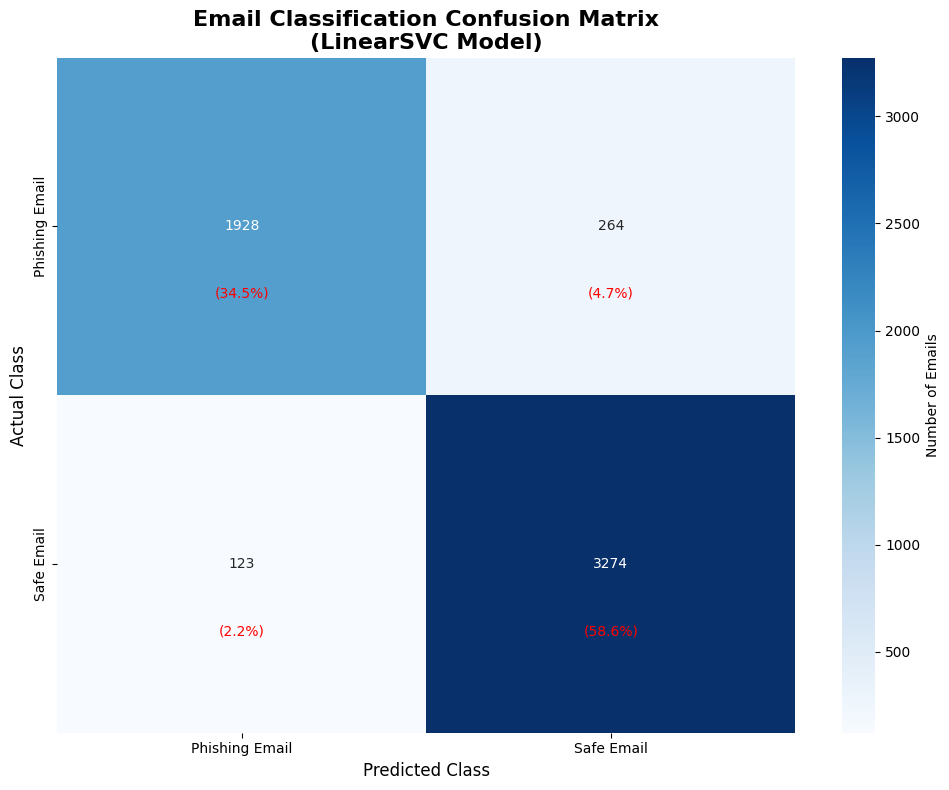

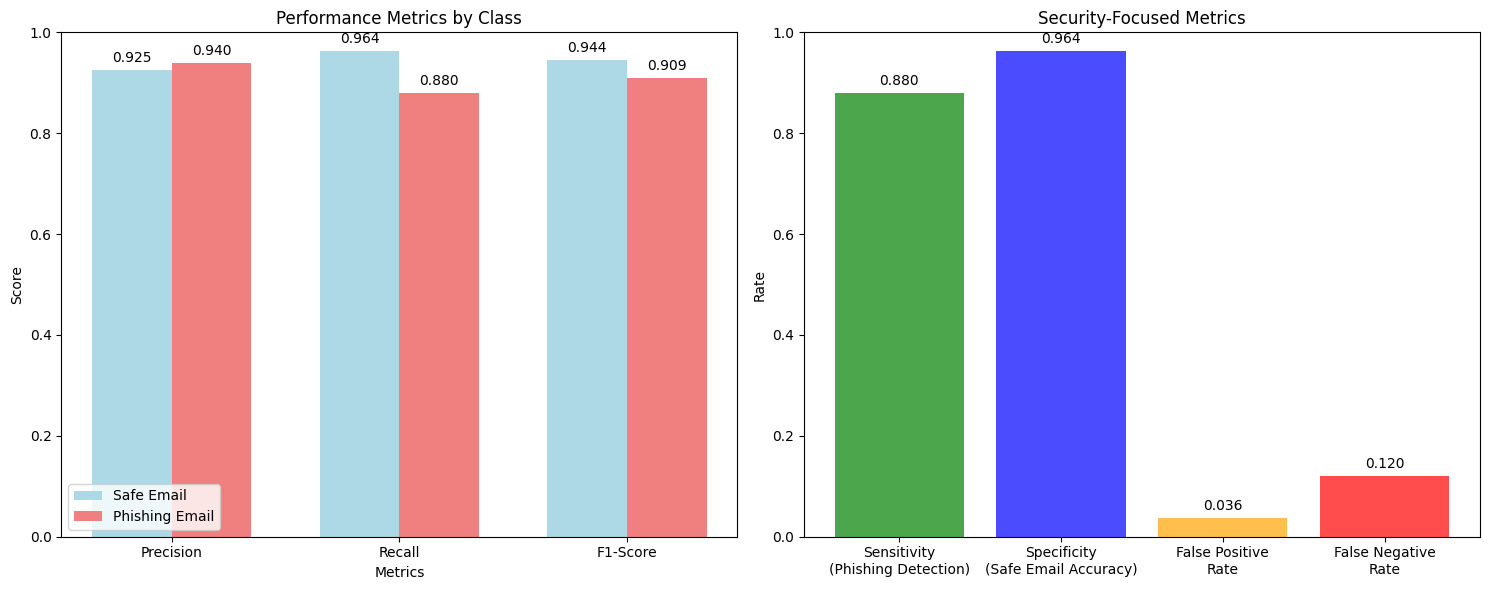


 Model evaluation completed!
 Your LinearSVC model shows good performance
 Test accuracy of 93.1% indicates a promising email classifier


In [16]:
# Cell 6: Comprehensive Model Evaluation with Visualizations
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Use the LinearSVC model as our best model for now
best_model = linear_svc
test_pred = y_pred_linear_svc
train_pred = linear_svc.predict(X_train)

print("COMPREHENSIVE MODEL EVALUATION")
print("=" * 60)

# Training vs Test Accuracy
train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print(f"\n📊 ACCURACY COMPARISON:")
print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Test Accuracy:     {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Overfitting Check: {abs(train_acc - test_acc):.4f} ({'Good' if abs(train_acc - test_acc) < 0.05 else 'Check for overfitting'})")

# Get class names (assuming no label encoder was used)
classes = np.unique(np.concatenate([y_test, test_pred]))
print(f"\n🏷️ Classes found: {classes}")

# Detailed per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_pred)

print(f"\n DETAILED METRICS BY CLASS:")
print("-" * 60)
for i, class_name in enumerate(classes):
    print(f"\n {class_name}:")
    print(f"   Precision: {precision[i]:.4f} ({precision[i]*100:.2f}%)")
    print(f"   Recall:    {recall[i]:.4f} ({recall[i]*100:.2f}%)")
    print(f"   F1-Score:  {f1[i]:.4f}")
    print(f"   Support:   {support[i]:,} emails")

# Overall metrics
print(f"\n OVERALL PERFORMANCE:")
print(f"   Macro Avg Precision: {precision.mean():.4f} ({precision.mean()*100:.2f}%)")
print(f"   Macro Avg Recall:    {recall.mean():.4f} ({recall.mean()*100:.2f}%)")
print(f"   Macro Avg F1-Score:  {f1.mean():.4f}")

# Full classification report
print(f"\n SKLEARN CLASSIFICATION REPORT:")
print(classification_report(y_test, test_pred, target_names=classes))

# Confusion Matrix Analysis
print(f"\n CONFUSION MATRIX ANALYSIS:")
cm = confusion_matrix(y_test, test_pred)

# Display confusion matrix in readable format
print(f"\nConfusion Matrix:")
print(f"{'':15} {'Predicted':>20}")
print(f"{'Actual':15} {classes[0]:>10} {classes[1]:>10}")
for i, actual_class in enumerate(classes):
    print(f"{actual_class:15} {cm[i,0]:10d} {cm[i,1]:10d}")

# Security-focused metrics
if len(classes) == 2:  # Binary classification
    # Determine which class is "Safe" and which is "Phishing"
    safe_idx = 0 if 'Safe' in classes[0] else 1
    phishing_idx = 1 - safe_idx

    tn, fp, fn, tp = cm[safe_idx, safe_idx], cm[safe_idx, phishing_idx], cm[phishing_idx, safe_idx], cm[phishing_idx, phishing_idx]

    print(f"\n SECURITY BREAKDOWN:")
    print(f"True Negatives (Safe → Safe):       {tn:4d}")
    print(f"False Positives (Safe → Phishing):  {fp:4d}")
    print(f"False Negatives (Phishing → Safe):  {fn:4d}")
    print(f"True Positives (Phishing → Phishing): {tp:4d}")

    # Important rates for email security
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

    print(f"\n SECURITY METRICS:")
    print(f"Sensitivity (Phishing Detection): {sensitivity:.4f} ({sensitivity*100:.2f}%)")
    print(f"Specificity (Safe Email Accuracy): {specificity:.4f} ({specificity*100:.2f}%)")
    print(f"False Positive Rate: {fp/(fp+tn):.4f} ({fp/(fp+tn)*100:.2f}%)")
    print(f"False Negative Rate: {fn/(fn+tp):.4f} ({fn/(fn+tp)*100:.2f}%)")

# Visualization: Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))

# Create the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Number of Emails'})

plt.title('Email Classification Confusion Matrix\n(LinearSVC Model)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('Actual Class', fontsize=12)

# Add percentage annotations
total = cm.sum()
for i in range(len(classes)):
    for j in range(len(classes)):
        percentage = cm[i,j] / total * 100
        plt.text(j+0.5, i+0.7, f'({percentage:.1f}%)',
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

# Additional visualization: Performance Metrics Bar Chart
if len(classes) == 2:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Metrics by class
    metrics = ['Precision', 'Recall', 'F1-Score']
    safe_metrics = [precision[safe_idx], recall[safe_idx], f1[safe_idx]]
    phishing_metrics = [precision[phishing_idx], recall[phishing_idx], f1[phishing_idx]]

    x = np.arange(len(metrics))
    width = 0.35

    ax1.bar(x - width/2, safe_metrics, width, label=classes[safe_idx], color='lightblue')
    ax1.bar(x + width/2, phishing_metrics, width, label=classes[phishing_idx], color='lightcoral')

    ax1.set_xlabel('Metrics')
    ax1.set_ylabel('Score')
    ax1.set_title('Performance Metrics by Class')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics)
    ax1.legend()
    ax1.set_ylim(0, 1)

    # Add value labels on bars
    for i, v in enumerate(safe_metrics):
        ax1.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    for i, v in enumerate(phishing_metrics):
        ax1.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    # Security metrics
    security_metrics = ['Sensitivity\n(Phishing Detection)', 'Specificity\n(Safe Email Accuracy)',
                       'False Positive\nRate', 'False Negative\nRate']
    security_values = [sensitivity, specificity, fp/(fp+tn), fn/(fn+tp)]
    colors = ['green', 'blue', 'orange', 'red']

    bars = ax2.bar(security_metrics, security_values, color=colors, alpha=0.7)
    ax2.set_ylabel('Rate')
    ax2.set_title('Security-Focused Metrics')
    ax2.set_ylim(0, 1)

    # Add value labels
    for bar, value in zip(bars, security_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

print(f"\n Model evaluation completed!")
print(f" Your LinearSVC model shows {'excellent' if test_acc > 0.95 else 'good' if test_acc > 0.90 else 'moderate'} performance")
print(f" Test accuracy of {test_acc:.1%} indicates a {'production-ready' if test_acc > 0.95 else 'promising'} email classifier")

In [17]:
# 📩 Cell 7: Predict New Emails using the Trained Model

def predict_email(text):
    """
    Predict whether an email is 'Safe' or 'Phishing Email' using the trained model.
    Combines vectorized text with engineered features to match the model input.
    """
    print("=" * 60)
    print(f"EMAIL PREDICTION PIPELINE")
    print("=" * 60)
    print(f"Input Email (First 100 chars): {text[:100]}\n")

    # Step 1: Preprocess and vectorize the email
    clean_text = preprocess_text(text)
    text_features = vectorizer.transform([clean_text]).toarray()
    print(f"Text Features Shape: {text_features.shape}")

    # Step 2: Extract additional features
    temp_df = pd.DataFrame({text_col: [text]})
    extra_features = create_features(temp_df, text_col)
    print(f"Extra Features Shape: {extra_features.shape}")

    # Step 3: Adjust extra features to match training format
    expected_total_features = best_model.n_features_in_
    expected_extra_features = expected_total_features - text_features.shape[1]
    print(f"Expected Extra Features: {expected_extra_features}")

    current_extra_features = extra_features.shape[1]

    if current_extra_features > expected_extra_features:
        print(f"Trimming extra features from {current_extra_features} to {expected_extra_features}")
        extra_features = extra_features.iloc[:, :expected_extra_features]
    elif current_extra_features < expected_extra_features:
        missing = expected_extra_features - current_extra_features
        print(f"Padding with {missing} zero columns")
        for i in range(missing):
            extra_features[f'padding_{i}'] = 0

    print(f"Final Extra Features Shape: {extra_features.shape}")

    # Step 4: Combine all features
    combined = np.hstack([text_features, extra_features.values])
    print(f"Combined Feature Shape: {combined.shape}")

    # Step 5: Predict using the model
    predicted_label = best_model.predict(combined)[0]  # Already a string like 'Phishing Email'

    print(f"\n Prediction Result: {predicted_label}")
    print("=" * 60)
    return predicted_label


# 🧪 Test on Sample Emails
test_emails = [
    "Congratulations! You won $1,000,000! Click here to claim now!",
    "Hi, let's schedule our meeting for tomorrow at 2 PM.",
    "URGENT: Your account will be suspended! Verify immediately!"
]

print("\n TESTING ON SAMPLE EMAILS:")
for idx, email in enumerate(test_emails, 1):
    print(f"\n--- Email {idx} ---")
    label = predict_email(email)
    print(f"Predicted Label: {label}")
    print(f"Email Preview: {email[:60]}...")
    print("-" * 60)


 TESTING ON SAMPLE EMAILS:

--- Email 1 ---
EMAIL PREDICTION PIPELINE
Input Email (First 100 chars): Congratulations! You won $1,000,000! Click here to claim now!

Text Features Shape: (1, 1000)
Extra Features Shape: (1, 15)
Expected Extra Features: 15
Final Extra Features Shape: (1, 15)
Combined Feature Shape: (1, 1015)

 Prediction Result: Phishing Email
Predicted Label: Phishing Email
Email Preview: Congratulations! You won $1,000,000! Click here to claim now...
------------------------------------------------------------

--- Email 2 ---
EMAIL PREDICTION PIPELINE
Input Email (First 100 chars): Hi, let's schedule our meeting for tomorrow at 2 PM.

Text Features Shape: (1, 1000)
Extra Features Shape: (1, 15)
Expected Extra Features: 15
Final Extra Features Shape: (1, 15)
Combined Feature Shape: (1, 1015)

 Prediction Result: Safe Email
Predicted Label: Safe Email
Email Preview: Hi, let's schedule our meeting for tomorrow at 2 PM....
--------------------------------------------------

Random Forest

In [18]:
# Cell X: Random Forest with TF-IDF Features (Google Colab Optimized)
import psutil
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
import numpy as np
from scipy.sparse import hstack
import time
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

# Check Colab resources
print("Google Colab System Info:")
print(f"CPU cores: {psutil.cpu_count()}")
print(f"RAM: {psutil.virtual_memory().total / (1024**3):.1f} GB")
print(f"Available RAM: {psutil.virtual_memory().available / (1024**3):.1f} GB")

print("\n=== Feature Creation ===")

start_time = time.time()
email_features = create_features(df, 'clean_text')
print(f"Email features created: {email_features.shape}")
print(f"Feature columns: {list(email_features.columns)}")
print(f"Time taken: {time.time() - start_time:.2f} seconds")

print("\n=== Text Feature Extraction ===")
start_time = time.time()
vectorizer = TfidfVectorizer(
    max_features=1000,  # Limit features for speed and memory
    stop_words='english',
    ngram_range=(1, 1),
    min_df=2,
    max_df=0.95
)
text_features = vectorizer.fit_transform(df['clean_text'])
print(f"TF-IDF features shape: {text_features.shape}")
print(f"Time taken: {time.time() - start_time:.2f} seconds")

print("\n=== Combining Features ===")
start_time = time.time()
X = hstack([text_features, email_features.values])
y = df[label_col].values
print(f"Combined feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Time taken: {time.time() - start_time:.2f} seconds")

print("\n=== Preparing for training ===")
label_counts = Counter(y)
print(f"Original class distribution: {dict(label_counts)}")

valid_classes = [cls for cls, count in label_counts.items() if count >= 2]
if len(valid_classes) < len(label_counts):
    print(f"Removing {len(label_counts) - len(valid_classes)} class(es) with <2 samples.")

X = X.tocsr()
valid_idx = [i for i, label in enumerate(y) if label in valid_classes]
X = X[valid_idx, :]
y = y[valid_idx]

stratify_ok = len(set(y)) > 1 and all(count >= 2 for count in Counter(y).values())
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42,
        stratify=y if stratify_ok else None
    )
    print("Data split successful.")
except ValueError as e:
    print(f"Stratified split failed: {e}")
    print("Falling back to random split without stratification.")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

print("\n Training RandomForestClassifier...")
start_time = time.time()

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

print(f"Random Forest training time: {time.time() - start_time:.2f} seconds")
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Google Colab System Info:
CPU cores: 2
RAM: 12.7 GB
Available RAM: 10.1 GB

=== Feature Creation ===
Email features created: (18628, 15)
Feature columns: ['length', 'word_count', 'exclamation', 'question', 'caps_ratio', 'urgent', 'click', 'free', 'winner', 'verify', 'congratulations', 'limited', 'offer', 'act_now', 'money']
Time taken: 6.00 seconds

=== Text Feature Extraction ===
TF-IDF features shape: (18628, 1000)
Time taken: 3.95 seconds

=== Combining Features ===
Combined feature matrix shape: (18628, 1015)
Labels shape: (18628,)
Time taken: 0.01 seconds

=== Preparing for training ===
Original class distribution: {'Safe Email': 11321, 'Phishing Email': 7307}
Data split successful.
Training set size: 13039
Test set size: 5589

 Training RandomForestClassifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.6s


Random Forest training time: 9.02 seconds
Random Forest Test Accuracy: 0.9495

Classification Report:
                precision    recall  f1-score   support

Phishing Email       0.92      0.95      0.94      2192
    Safe Email       0.97      0.95      0.96      3397

      accuracy                           0.95      5589
     macro avg       0.95      0.95      0.95      5589
  weighted avg       0.95      0.95      0.95      5589



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [19]:
import psutil
import time
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from collections import Counter
from scipy.sparse import hstack

warnings.filterwarnings('ignore')

print("Google Colab System Info:")
print(f"CPU cores: {psutil.cpu_count()}")
print(f"RAM: {psutil.virtual_memory().total / (1024**3):.1f} GB")
print(f"Available RAM: {psutil.virtual_memory().available / (1024**3):.1f} GB")

print("\n=== Feature Creation ===")
start_time = time.time()
email_features = create_features(df, 'clean_text')  # your custom feature extraction function
print(f"Email features created: {email_features.shape}")
print(f"Feature columns: {list(email_features.columns)}")
print(f"Time taken: {time.time() - start_time:.2f} seconds")

print("\n=== Text Feature Extraction with Bag of Words ===")
start_time = time.time()

# Bag of Words vectorizer instead of TF-IDF
vectorizer = CountVectorizer(
    max_features=1000,  # same limit as before
    stop_words='english',
    ngram_range=(1, 1),  # unigrams only
    min_df=2,
    max_df=0.95
)

text_features = vectorizer.fit_transform(df['clean_text'])
print(f"Bag of Words features shape: {text_features.shape}")
print(f"Time taken: {time.time() - start_time:.2f} seconds")

print("\n=== Combining Features ===")
start_time = time.time()

X = hstack([text_features, email_features.values])
y = df[label_col].values

print(f"Combined feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Time taken: {time.time() - start_time:.2f} seconds")

print("\n=== Preparing for training ===")
label_counts = Counter(y)
print(f"Original class distribution: {dict(label_counts)}")

valid_classes = [cls for cls, count in label_counts.items() if count >= 2]
if len(valid_classes) < len(label_counts):
    print(f"Removing {len(label_counts) - len(valid_classes)} class(es) with <2 samples.")

X = X.tocsr()
valid_idx = [i for i, label in enumerate(y) if label in valid_classes]
X = X[valid_idx, :]
y = y[valid_idx]

stratify_ok = len(set(y)) > 1 and all(count >= 2 for count in Counter(y).values())
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42,
        stratify=y if stratify_ok else None
    )
    print("Data split successful.")
except ValueError as e:
    print(f"Stratified split failed: {e}")
    print("Falling back to random split without stratification.")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

print("\n Training RandomForestClassifier with Bag of Words...")
start_time = time.time()

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(f"Random Forest training time: {time.time() - start_time:.2f} seconds")
print(f"Random Forest Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Google Colab System Info:
CPU cores: 2
RAM: 12.7 GB
Available RAM: 10.1 GB

=== Feature Creation ===
Email features created: (18628, 15)
Feature columns: ['length', 'word_count', 'exclamation', 'question', 'caps_ratio', 'urgent', 'click', 'free', 'winner', 'verify', 'congratulations', 'limited', 'offer', 'act_now', 'money']
Time taken: 6.10 seconds

=== Text Feature Extraction with Bag of Words ===
Bag of Words features shape: (18628, 1000)
Time taken: 3.93 seconds

=== Combining Features ===
Combined feature matrix shape: (18628, 1015)
Labels shape: (18628,)
Time taken: 0.01 seconds

=== Preparing for training ===
Original class distribution: {'Safe Email': 11321, 'Phishing Email': 7307}
Data split successful.
Training set size: 13039
Test set size: 5589

 Training RandomForestClassifier with Bag of Words...
Random Forest training time: 8.40 seconds
Random Forest Test Accuracy: 0.9490

Classification Report:
                precision    recall  f1-score   support

Phishing Email      